In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import time
import yfinance as yf

### Using Monte-Carlo method for finding optimal Sharpe ratios in cryptocurrency portfolios

First, we'll use the yahoo finance API to get stock price data for four coins--bitcoin, ethereum, litecoin, and ripple

In [2]:
coins = [
    'BTC-USD',
    'ETH-USD',
    'LTC-USD',
    'XRP-USD',
    ]

In [3]:
def get_data(tickers):
    """Read in daily price(adjusted close) of asset for a given set of dates."""
        
    # download daily price data for each of the stocks in the portfolio
    df = yf.download(tickers)['Adj Close']
    
    return df

In [4]:
crypto_prices = get_data(coins)
print(crypto_prices.head())

[*********************100%***********************]  4 of 4 completed
               BTC-USD  ETH-USD  LTC-USD   XRP-USD
Date                                              
2014-09-17  457.334015      NaN  5.05855  0.005399
2014-09-18  424.440002      NaN  4.68523  0.005135
2014-09-19  394.795990      NaN  4.32777  0.004942
2014-09-20  408.903992      NaN  4.28644  0.004772
2014-09-21  398.821014      NaN  4.24592  0.004570


#### Next, we'll define a function for calculating daily returns for our coins

In [5]:
def calc_daily_returns(df):
    return (df.pct_change())

In [6]:
crypto_daily_rets = calc_daily_returns(crypto_prices)
print(crypto_daily_rets.head())

             BTC-USD  ETH-USD   LTC-USD   XRP-USD
Date                                             
2014-09-17       NaN      NaN       NaN       NaN
2014-09-18 -0.071926      NaN -0.073800 -0.048898
2014-09-19 -0.069843      NaN -0.076295 -0.037585
2014-09-20  0.035735      NaN -0.009550 -0.034399
2014-09-21 -0.024659      NaN -0.009453 -0.042330


#### Define a function for calculating mean daily returns for our coins

In [7]:
def calc_mean_daily_returns(daily_returns):
    return (daily_returns.mean())

In [8]:
crypto_mean_daily_rets = calc_mean_daily_returns(crypto_daily_rets)
print(crypto_mean_daily_rets.head())

BTC-USD    0.002809
ETH-USD    0.005395
LTC-USD    0.003174
XRP-USD    0.004243
dtype: float64


#### Define a function for creating covariance matrices

In [9]:
def create_covariance_matrix(daily_returns):
    return daily_returns.cov()

In [10]:
crypto_cov_matrix = create_covariance_matrix(crypto_daily_rets)
print(crypto_cov_matrix)

          BTC-USD   ETH-USD   LTC-USD   XRP-USD
BTC-USD  0.001516  0.001256  0.001407  0.000916
ETH-USD  0.001256  0.004219  0.001743  0.001403
LTC-USD  0.001407  0.001743  0.003362  0.001529
XRP-USD  0.000916  0.001403  0.001529  0.005774


#### Below is a function to calculate and return a dataframe with portfolio returns, standard deviations, and sharpe ratios for a specified number of randomly weighted portfolios consisting of our four coins

In [11]:
def create_results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(len(tickers)))

        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # Create initial column list
    column_list = [
        'ret',
        'stdev',
        'sharpe',
    ]

    # Add each ticker as a column
    for i in range(len(tickers)):
        {
            column_list.append(tickers[i])
        }

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=column_list)
    
    return results_df

In [12]:
crypto_results = create_results_dataframe(coins, 10000, crypto_mean_daily_rets, crypto_cov_matrix)
print(crypto_results.head())

        ret     stdev    sharpe   BTC-USD   ETH-USD   LTC-USD   XRP-USD
0  1.098446  0.779059  1.392123  0.066574  0.399791  0.233156  0.300479
1  0.840995  0.645658  1.281010  0.536935  0.039808  0.170021  0.253236
2  1.006106  0.779748  1.272470  0.103315  0.375942  0.500785  0.019958
3  0.965655  0.667214  1.426461  0.388480  0.293969  0.180307  0.137244
4  0.988985  0.764913  1.274766  0.281793  0.161101  0.093654  0.463453


#### Define a function to find the portfolio with the highest sharpe ratio 

In [13]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df['sharpe'].idxmax()]

In [14]:
crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
print(crypto_max_sharpe_portfolio)

ret        1.054931
stdev      0.705138
sharpe     1.476352
BTC-USD    0.378337
ETH-USD    0.427122
LTC-USD    0.006119
XRP-USD    0.188422
Name: 2638, dtype: float64


#### Define a function to find the portfolio with the lowest volatility 

In [15]:
def min_volatility(results_df):
    """locate portfolio with lowest volatility"""
    return results_df.iloc[results_df['stdev'].idxmin()]

In [16]:
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

ret        0.783252
stdev      0.603707
sharpe     1.274379
BTC-USD    0.803111
ETH-USD    0.039468
LTC-USD    0.027069
XRP-USD    0.130351
Name: 4549, dtype: float64


#### Write func to plot all of the different portfolios consisting of different mixtures (weights) for our four coins
#### Also, plot the portfolio with the highest Sharpe with a red star and the lowest volatility with a green star
#### Lastly, plot a color bar showing the sharpe ratio for all portfolios

In [17]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, 
                         c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('0.4444')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize = 14)

    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)


<ipython-input-17-573cf41c9e1e>:4: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, color='w', linestyle='-', linewidth=1)


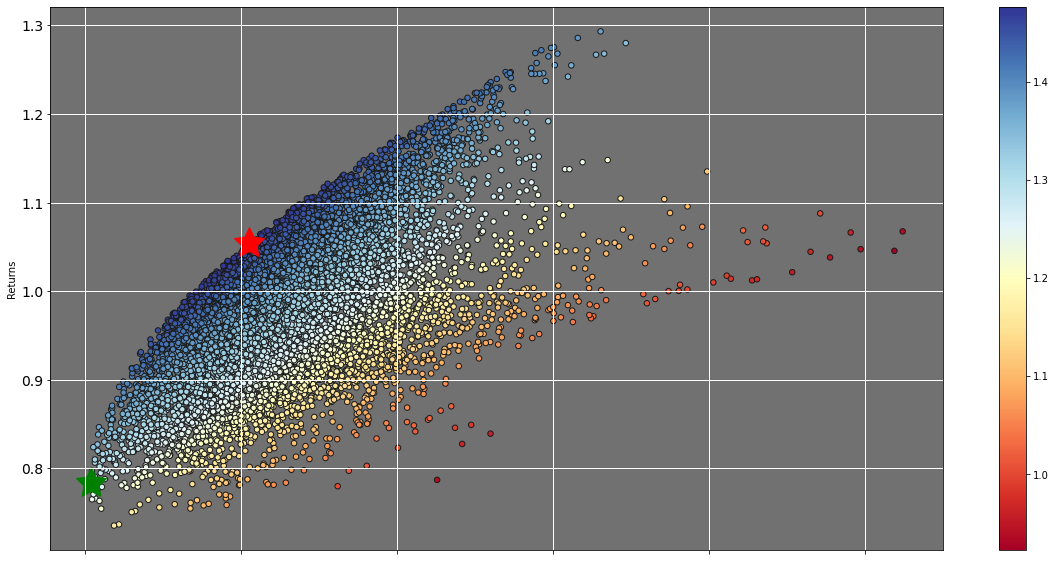

In [18]:
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)
plt.show()